<a href="https://colab.research.google.com/github/nvasin/StockAdvisor/blob/main/EDAs/VTBR_EDA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ticker = 'VTBR'
data = pd.read_csv(f'{ticker}_moex_10m_data.csv')

In [4]:
# import yfinance as yf


# start_date = '2022-03-01'
# end_date = '2024-11-01'
# data = yf.download('AAPL', start_date, end_date)

## Изучение структуры данных

In [5]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
date_range = str(data['Datetime'].dt.date.min()) + ' to ' + str(data['Datetime'].dt.date.max())
date_range

'2021-10-01 to 2024-11-02'

In [6]:
data.set_index('Datetime', inplace = True)

In [7]:
data.head()

,Open,High,Low,Close,Volume,Ticker
Datetime,,,,,,
2021-10-01 09:50:00,256.000,256.000,256.000,256.00,8.750000e+07,VTBR
2021-10-01 10:00:00,256.000,257.225,255.800,256.75,1.860030e+09,VTBR
2021-10-01 10:10:00,256.875,257.175,255.775,256.15,1.331140e+09,VTBR
2021-10-01 10:20:00,256.100,256.350,255.225,255.65,8.722200e+08,VTBR
2021-10-01 10:30:00,255.775,255.775,254.150,254.70,2.468760e+09,VTBR


In [8]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Ticker,0


In [9]:
data.describe()

,Open,High,Low,Close,Volume
count,302755.000000,302755.000000,302755.000000,302755.000000,3.027550e+05
mean,123.941740,124.133906,123.721270,123.937311,1.093984e+09
std,51.709301,51.797240,51.607703,51.707449,2.313867e+09
min,70.125000,70.125000,69.400000,70.125000,7.550000e+02
25%,90.200000,90.325000,90.025000,90.200000,1.523400e+08
50%,111.200000,111.375000,110.975000,111.200000,4.466700e+08
75%,125.050000,125.175000,124.925000,125.050000,1.119590e+09
max,287.350000,287.500000,286.925000,287.375000,7.704141e+10


> Структура данных - OHLC.

> Данные с временным шагом 10 минут.

> За период 01.10.2021 - 02.11.2024.

> Пропуски отсутствуют.

## Первичная визуализация

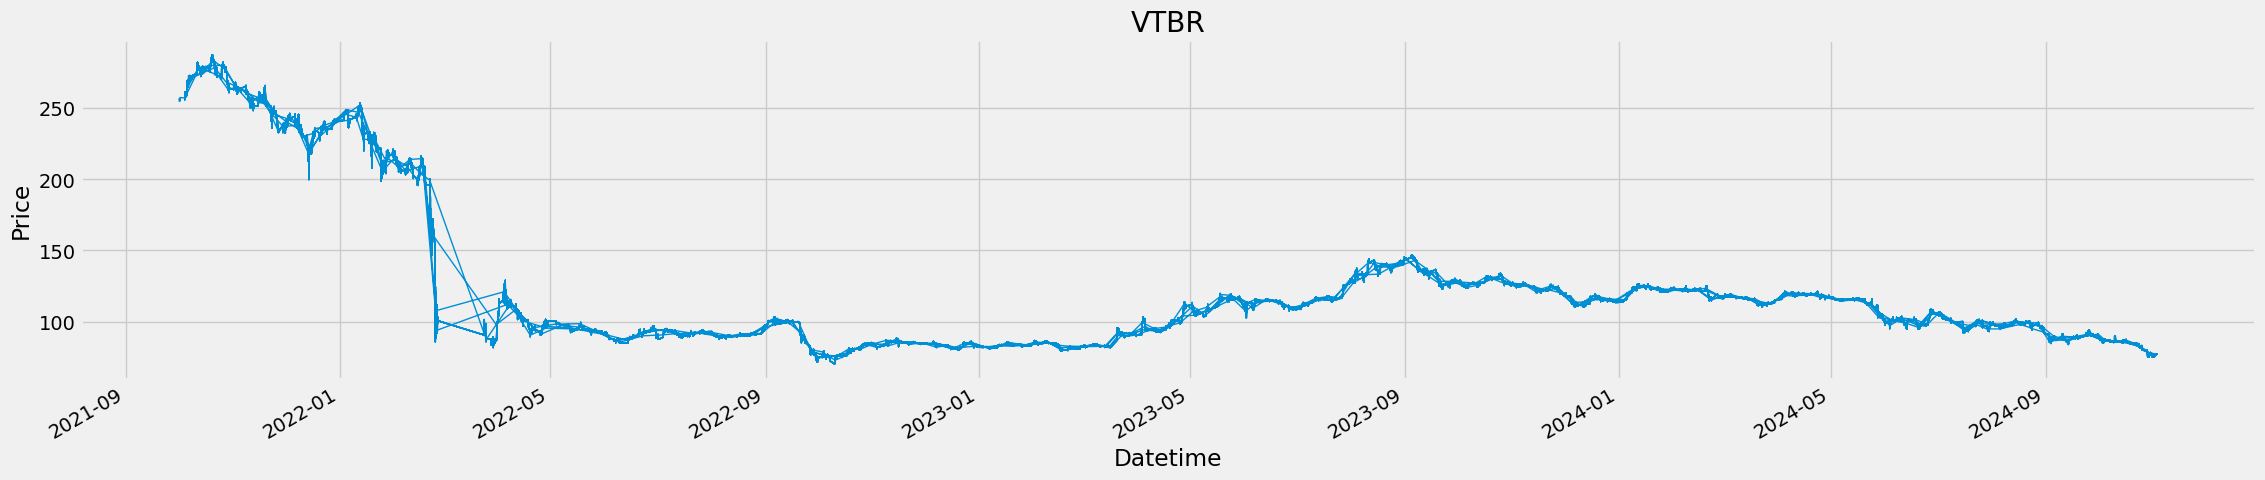

In [12]:
data['Close'].plot()
plt.title(ticker)
plt.ylabel("Price")
plt.rc("figure", figsize=(25,5))
plt.show()

array([<Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>], dtype=object)

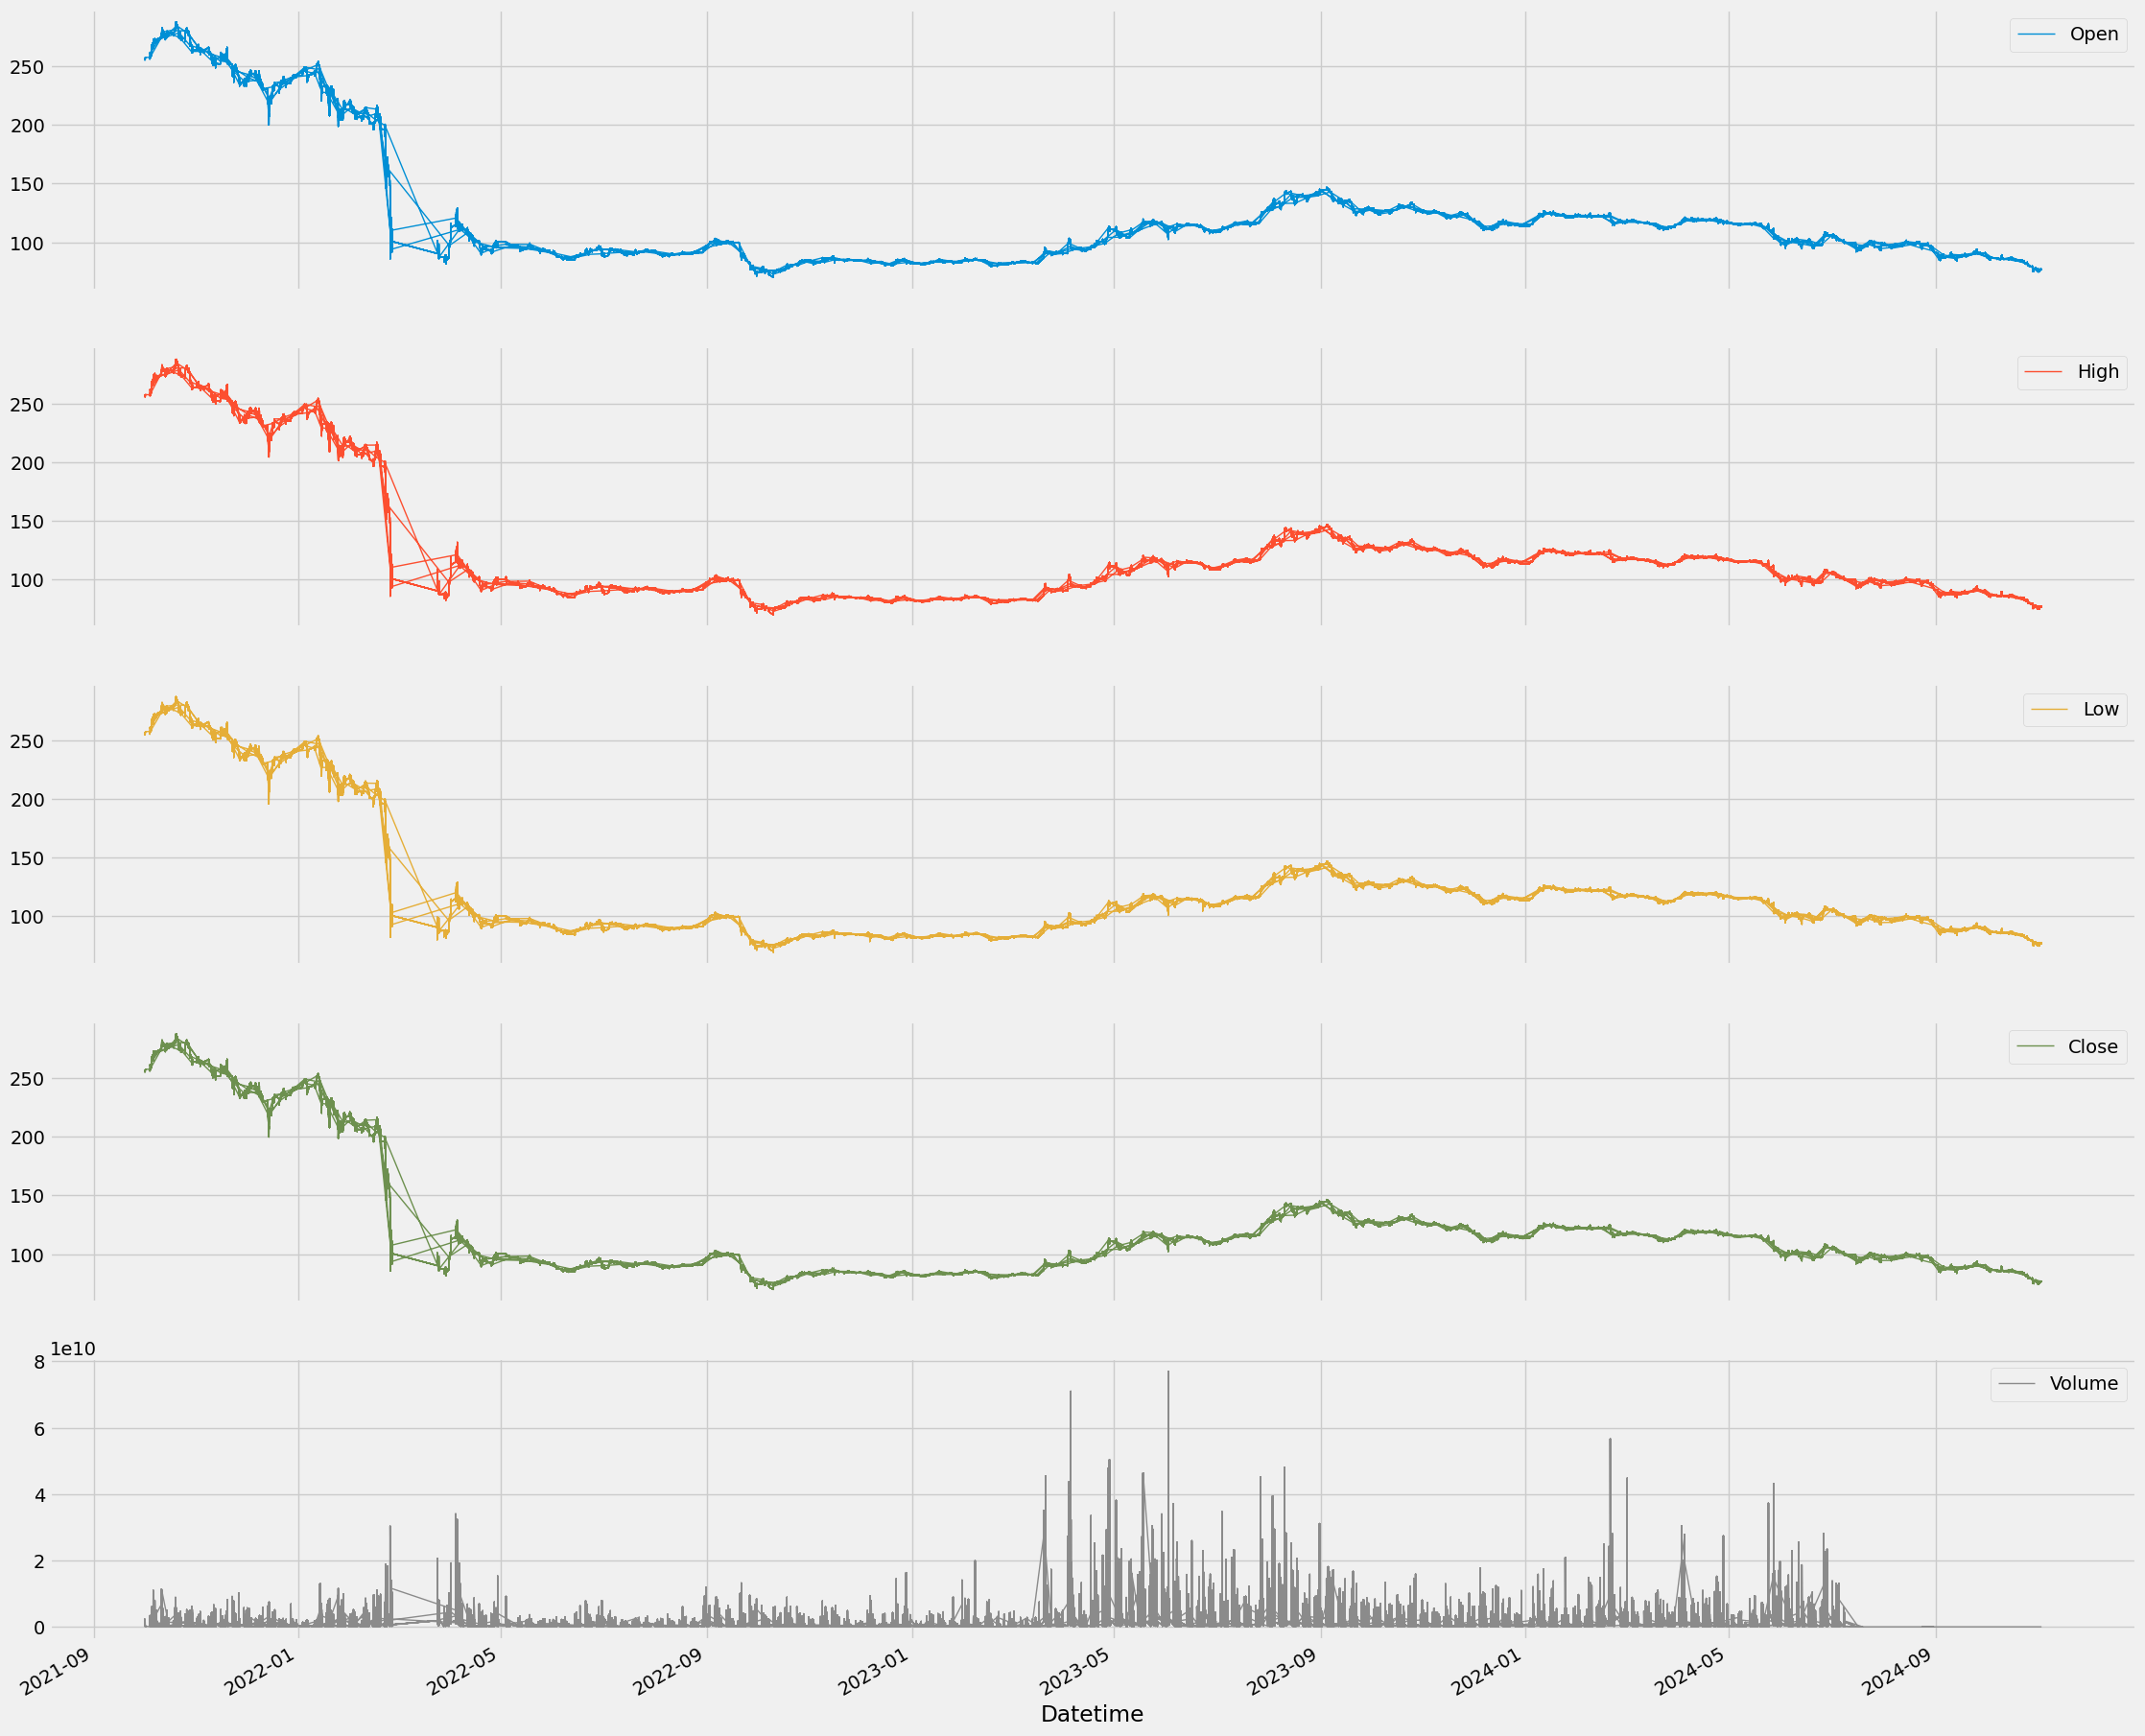

In [11]:
plt.style.use("fivethirtyeight")
plt.rcParams['lines.linewidth'] = 1
data.plot(subplots=True, figsize=(25, 25))

<ipython-input-13-28a892581506>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data['Close'].resample("M").sum().plot()


Text(0.5, 1.0, 'Resampled  - Month')

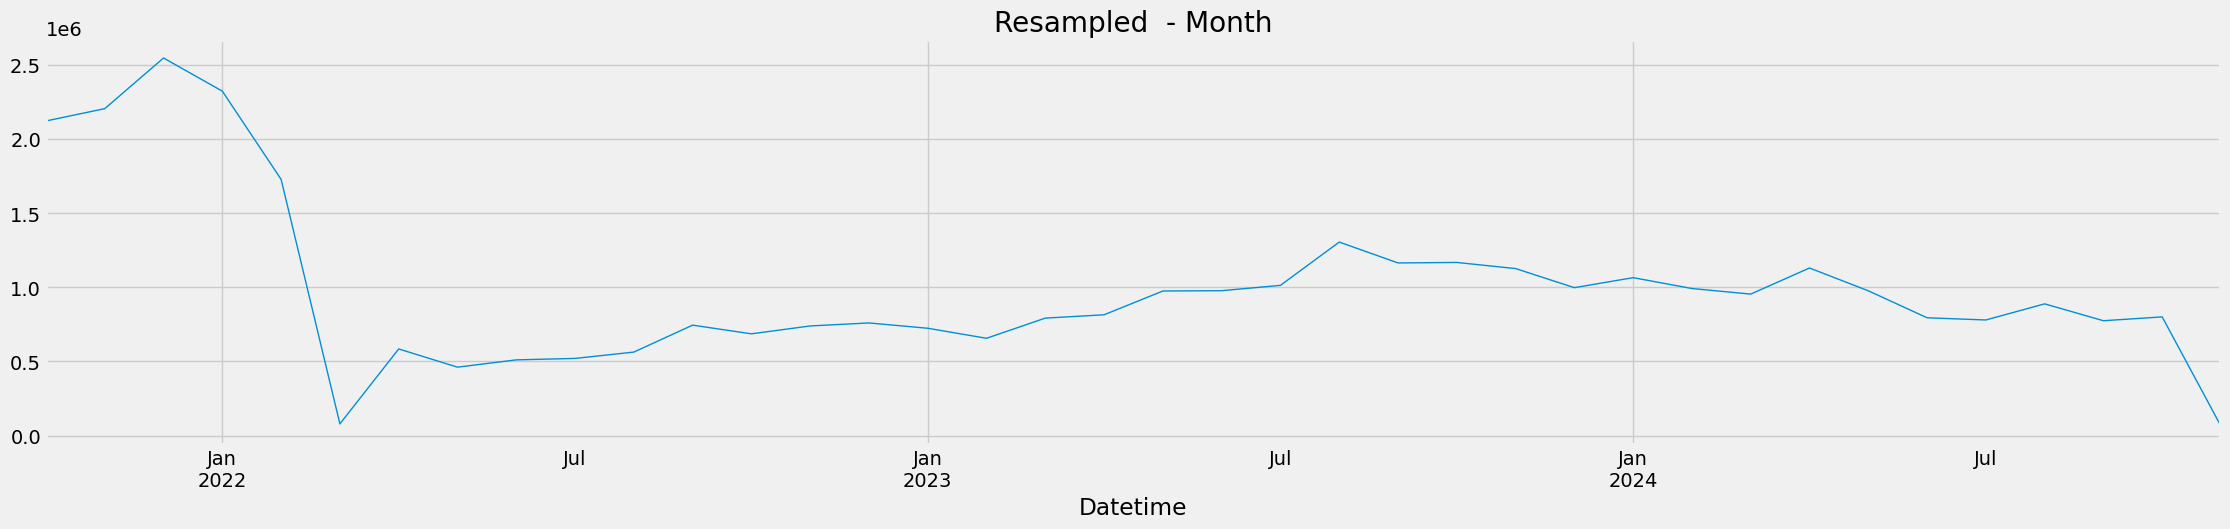

In [13]:
data['Close'].resample("M").sum().plot()
plt.title('Resampled  - Month')

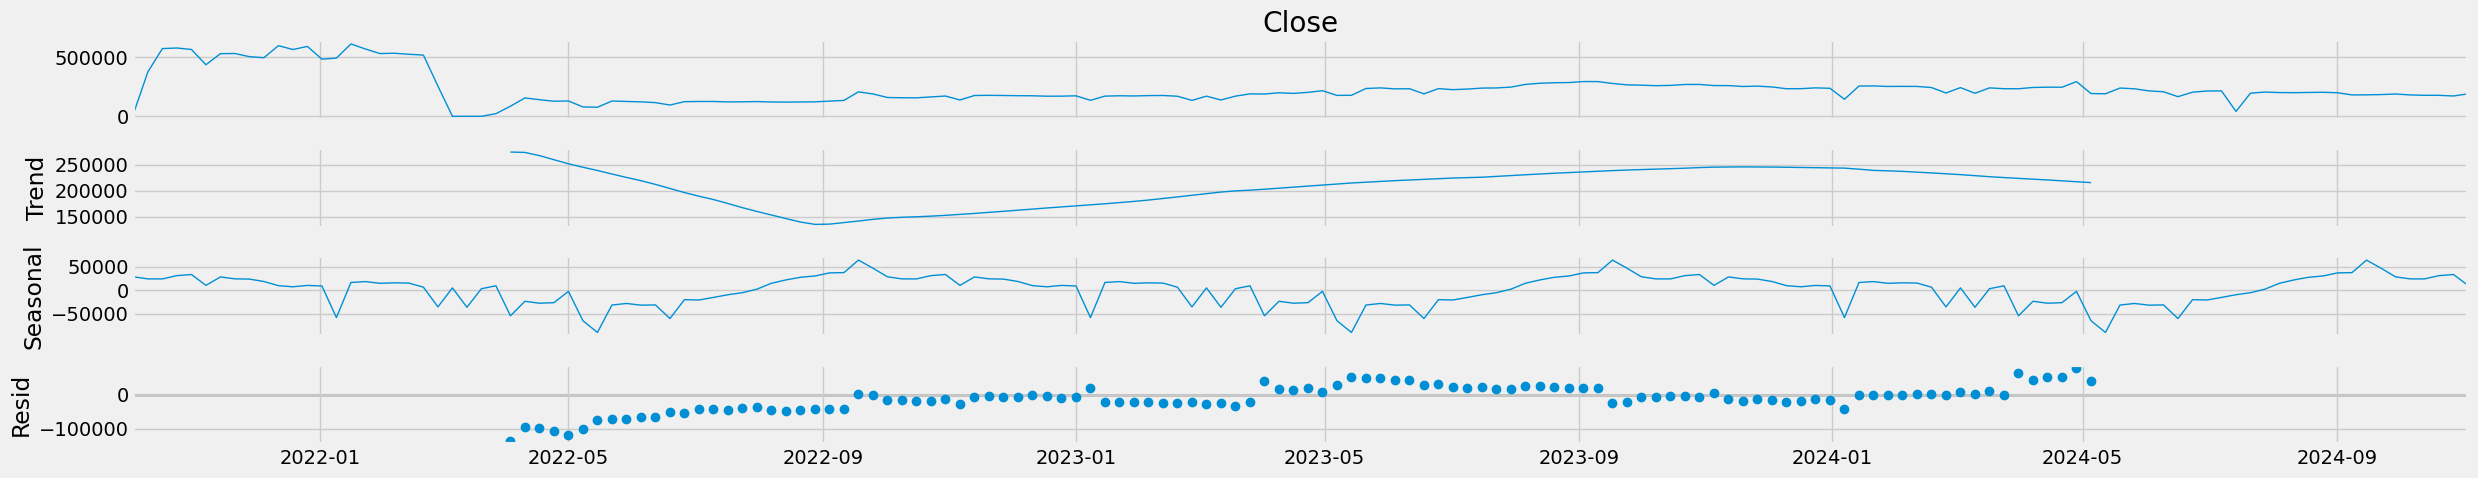

In [14]:
import statsmodels.api as sm


res = sm.tsa.seasonal_decompose(data['Close'].resample("W").sum())
resplot = res.plot()

> Сезонности нет.

## Статистические характеристики

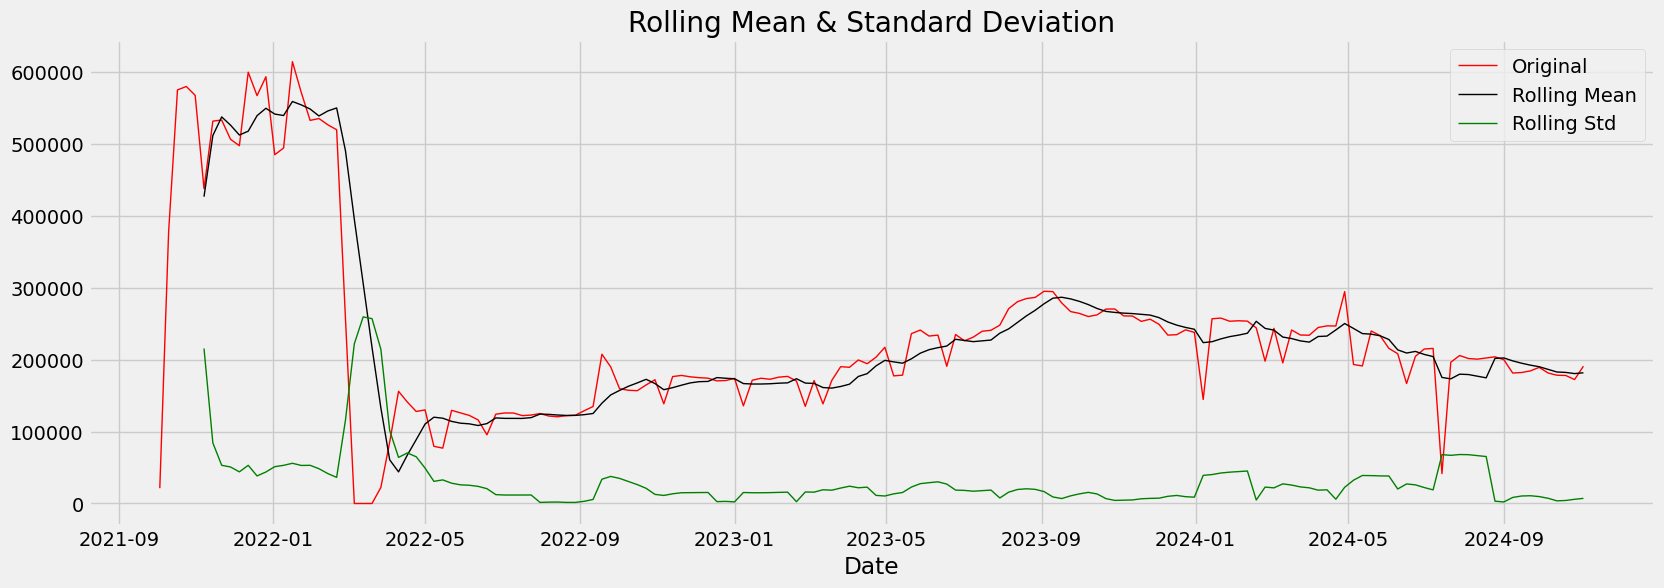

In [15]:
X = data['Close'].resample("W").sum()

rolmean = X.rolling(6).mean()
rolstd = X.rolling(6).std()

plt.figure(figsize=(18,6))
orig = plt.plot(X, color='red',label='Original')
mean = plt.plot(rolmean, color='black', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.xlabel("Date")
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

> Нестационарный временной ряд.

## Специальные тесты TS

ADF

In [16]:
from statsmodels.tsa.stattools import adfuller


X = data['Close'].resample("W").sum().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.092049
p-value: 0.027147


ACF

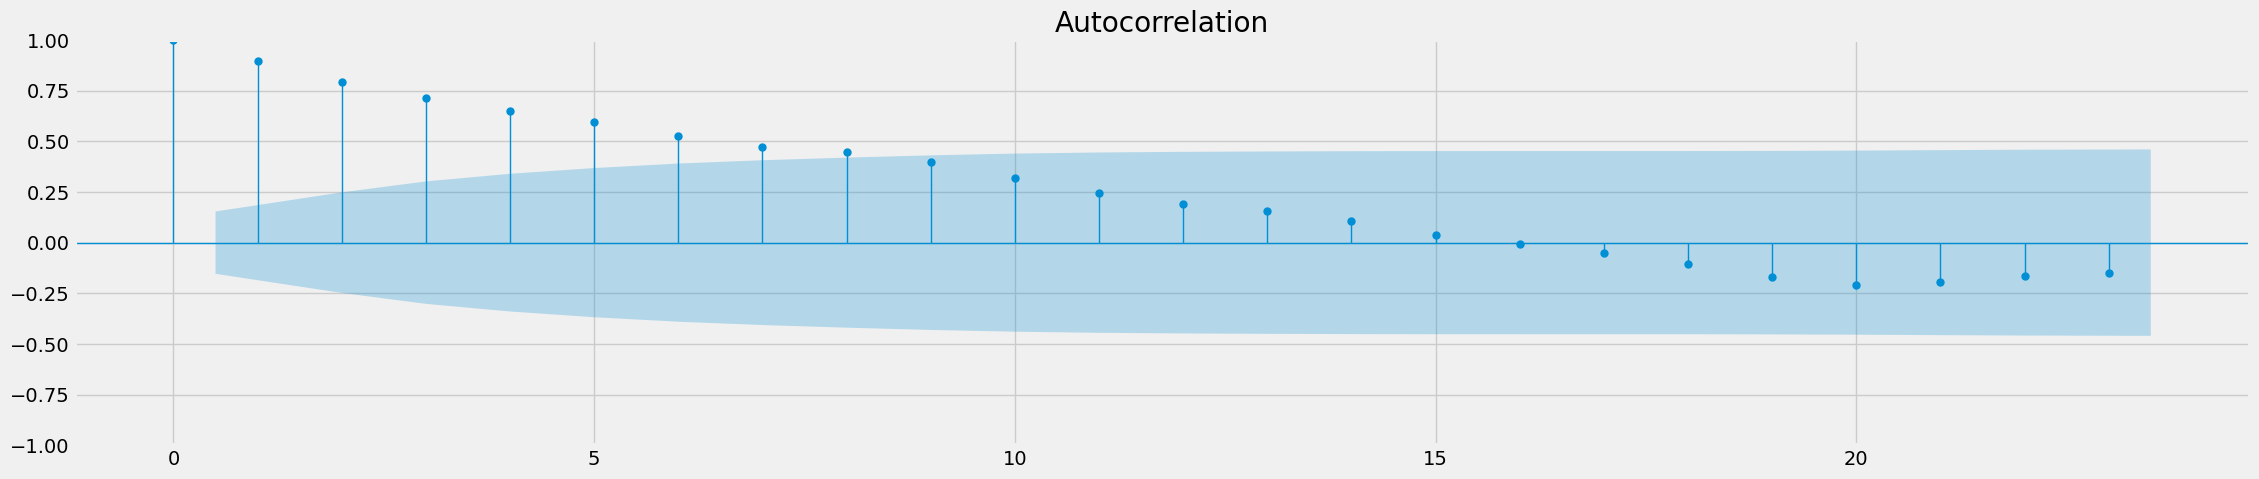

In [17]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(X)
plt.show()

PACF

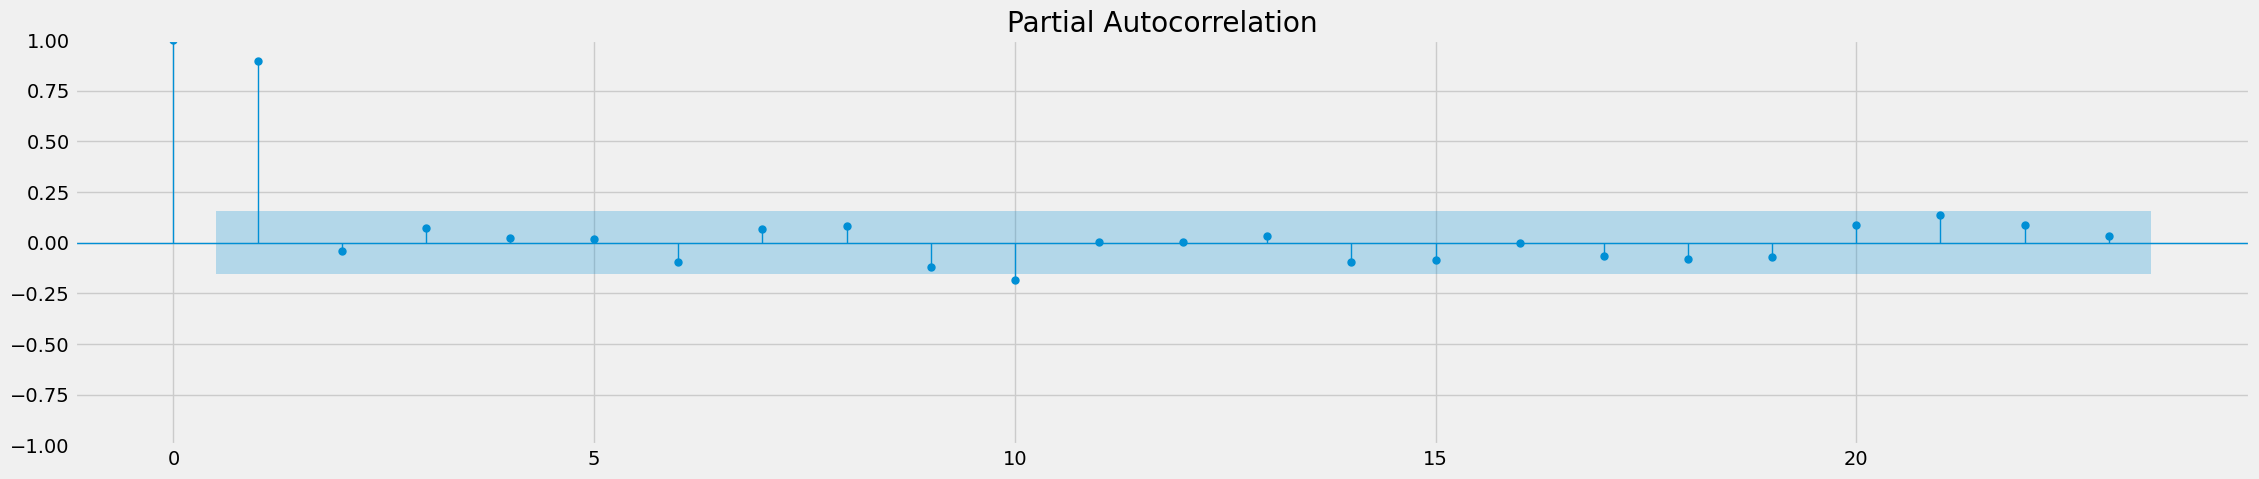

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(X, lags=23)
plt.show()

## Дополнительно

In [19]:
data_2 = data.copy()

In [20]:
data_2['year'] = [x for x in data_2.index.year]
data_2['month'] = [x for x in data_2.index.month]
data_2 = data_2.reset_index()
data_2['week'] = data_2['Datetime'].apply(lambda x:x.week)
data_2 = data_2.set_index('Datetime')
data_2['hour'] = [x for x in data_2.index.hour]
data_2['day'] = [x for x in data_2.index.day_of_week]
data_2['day_str'] = [x.strftime('%a') for x in data_2.index]
data_2['year_month'] = [str(x.year) + '_' + str(x.month) for x in data_2.index]

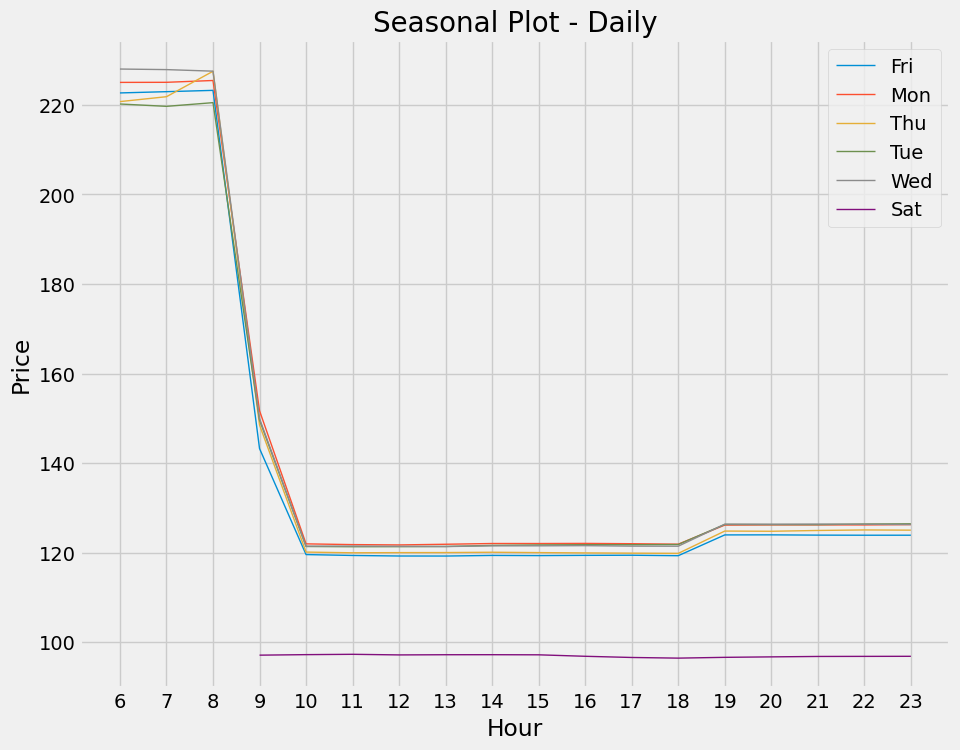

In [21]:
import seaborn as sns


df_plot = data_2[['hour', 'day_str', 'Close']].dropna().groupby(['hour', 'day_str']).mean()[['Close']].reset_index()

plt.figure(figsize=(10,8))
sns.lineplot(data = df_plot, x='hour', y='Close', hue='day_str', legend=True)
plt.locator_params(axis='x', nbins=24)
plt.title("Seasonal Plot - Daily", fontsize=20)
plt.ylabel('Price')
plt.xlabel('Hour')
plt.legend()

Text(0.5, 0, 'Year Month')

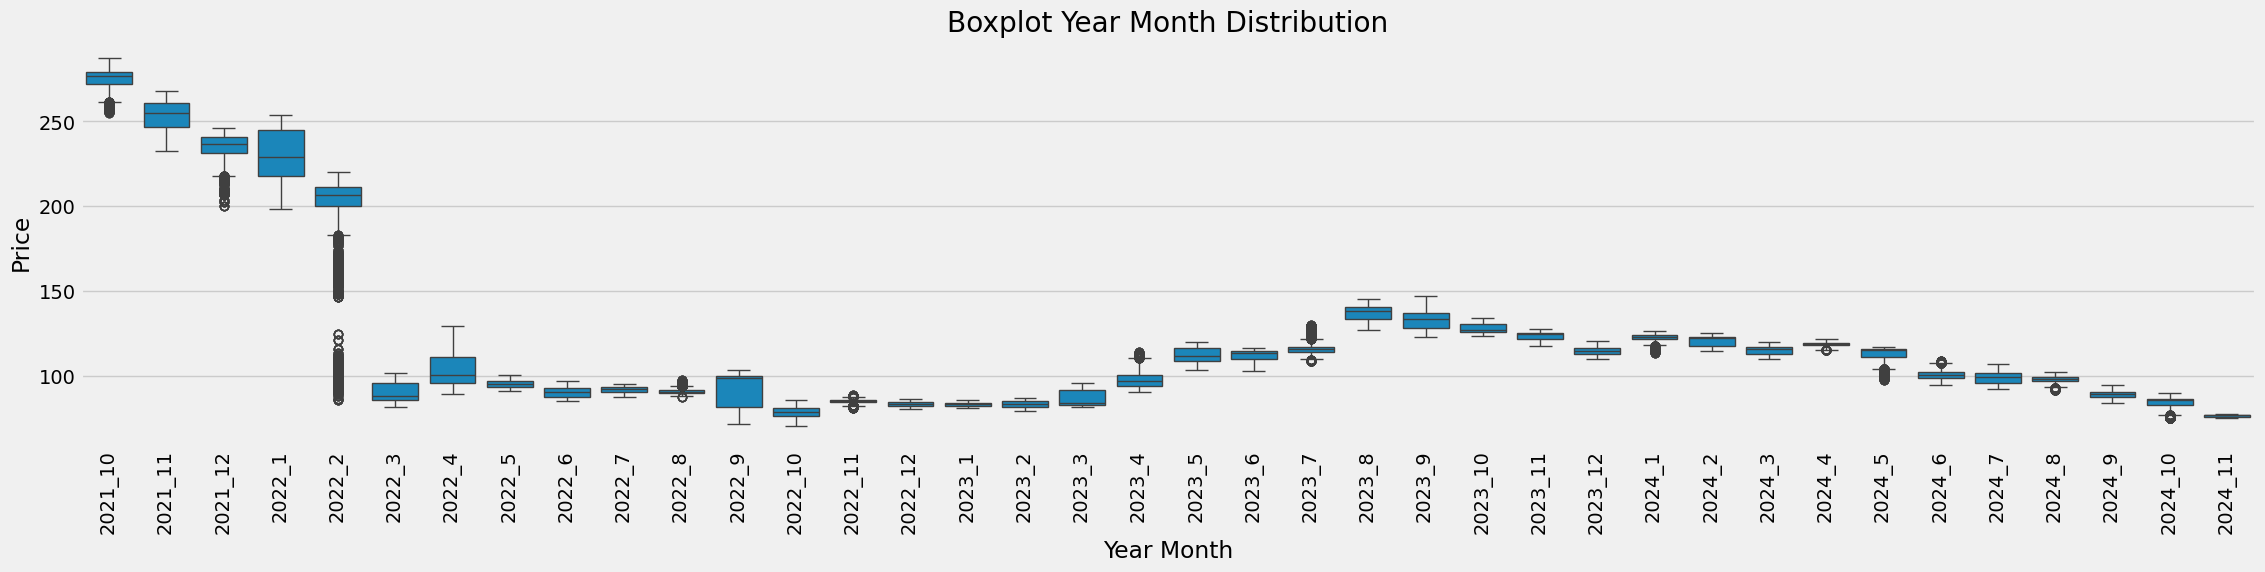

In [22]:
data_2['year'] = [x for x in data_2.index.year]
data_2['month'] = [x for x in data_2.index.month]
data_2['year_month'] = [str(x.year) + '_' + str(x.month) for x in data_2.index]

df_plot = data_2[data_2['year'] >= 2017].reset_index().sort_values(by='Datetime').set_index('Datetime')
plt.title(f'Boxplot Year Month Distribution');
plt.xticks(rotation=90)
plt.xlabel('Year Month')
plt.ylabel('MW')

sns.boxplot(x='year_month', y='Close', data=df_plot)
plt.ylabel('Price')
plt.xlabel('Year Month')